In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import pickle 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import dotenv

2024-11-21 00:13:19.007826: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 75
BATCH_SIZE = 128 
IMAGE_SIZE = 224  # ResNet50 input size

### Import Dataset

In [3]:
training_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Training')

class_labels = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
image_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels_reverse = {v: k for k, v in class_labels.items()}

In [4]:
# Initialize lists to store images and labels for the training dataset
images = []
labels = []

# Loop over the folders in the Training dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(training_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 for ResNet50

        # Append image and label (use list append method)
        images.append(img)
        labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
images = np.array(images)
labels = np.array(labels)

# Normalize the images (optional but helps with training)
images = images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
X_rgb = np.repeat(images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Split the dataset into training and validation sets (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_rgb, labels, test_size=0.2, random_state=42)

# Data augmentation to improve model generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load pre-trained ResNet50 model (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Unfreeze the base model layers to allow fine-tuning
base_model.trainable = True

In [5]:
# Add custom classifier layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Increased the number of neurons
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [6]:
# Train the model using the training data
datagen.fit(X_train)
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // BATCH_SIZE)

Epoch 1/75


I0000 00:00:1732166021.930305  123177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 62s 1s/step - loss: 1.5301 - accuracy: 0.7034 - val_loss: 2.8866 - val_accuracy: 0.2257
Epoch 2/75
35/35 [==============================] - 45s 1s/step - loss: 0.4090 - accuracy: 0.8705 - val_loss: 6.0756 - val_accuracy: 0.2546
Epoch 3/75
35/35 [==============================] - 47s 1s/step - loss: 0.2446 - accuracy: 0.9210 - val_loss: 5.0104 - val_accuracy: 0.2546
Epoch 4/75
35/35 [==============================] - 45s 1s/step - loss: 0.1912 - accuracy: 0.9333 - val_loss: 5.1938 - val_accuracy: 0.2546
Epoch 5/75
35/35 [==============================] - 45s 1s/step - loss: 0.1453 - accuracy: 0.9511 - val_loss: 6.5393 - val_accuracy: 0.2546
Epoch 6/75
35/35 [==============================] - 47s 1s/step - loss: 0.1220 - accuracy: 0.9608 - val_loss: 6.5523 - val_accuracy: 0.2546
Epoch 7/75
35/35 [==============================] - 45s 1s/step - loss: 0.1029 - accuracy: 0.9671 - val_loss: 4.8992 - val_accuracy: 0.2546
Epoch 8/75
35/35 [=============

In [7]:
# Save Model Output
model.save('classification2_model.h5')

# Save the model history to a file
with open('classification2_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


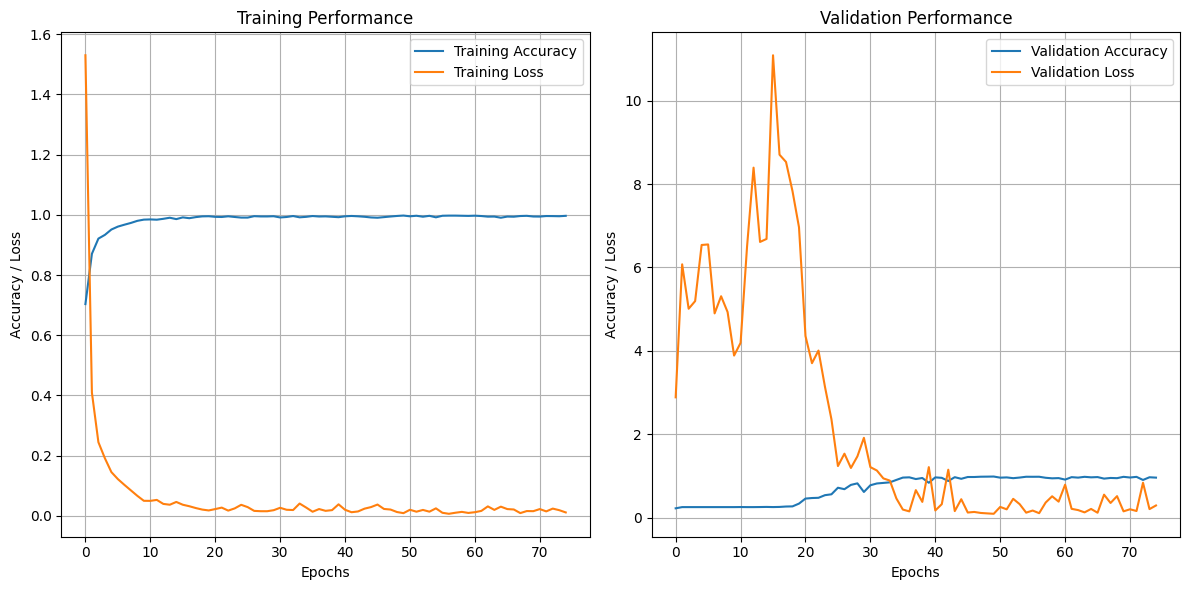

36/36 [==============================] - 4s 107ms/step - loss: 0.2938 - accuracy: 0.9615
Validation Loss: 0.29384028911590576
Validation Accuracy: 0.9615048170089722


In [8]:
# Training Graph: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Performance')
plt.legend()
plt.grid(True)

# Validation Graph: Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Validation Performance')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the validation (split) set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

1/1 [==============================] - 0s 108ms/step
Predicted label: glioma
Predicted label: meningioma
Predicted label: notumor
Predicted label: pituitary
41/41 [==============================] - 4s 105ms/step - loss: 0.1731 - accuracy: 0.9703
Testing Loss: 0.17311617732048035
Testing Accuracy: 0.970251739025116
41/41 [==============================] - 4s 100ms/step


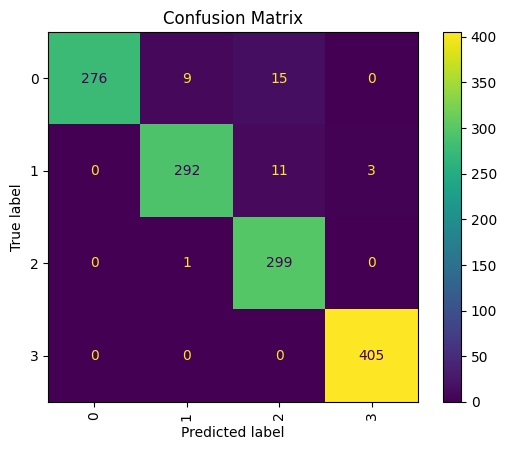

In [9]:
def test_image(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)  # Get the class index with the highest probability

    # Return the predicted label
    predicted_label = class_labels_reverse[predicted_class[0]]  # Map the class index to label
    return predicted_label

test_image_path1 = os.path.join(os.environ['DATASET_PATH'], 'Testing/glioma/Te-gl_0010.jpg')
test_image_path2 = os.path.join(os.environ['DATASET_PATH'], 'Testing/meningioma/Te-me_0018.jpg')
test_image_path3 = os.path.join(os.environ['DATASET_PATH'], 'Testing/notumor/Te-no_0027.jpg')
test_image_path4 = os.path.join(os.environ['DATASET_PATH'], 'Testing/pituitary/Te-pi_0094.jpg')

predicted_label1 = test_image(model, test_image_path1)
predicted_label2 = test_image(model, test_image_path2)
predicted_label3 = test_image(model, test_image_path3)
predicted_label4 = test_image(model, test_image_path4)

print(f"Predicted label: {predicted_label1}")
print(f"Predicted label: {predicted_label2}")
print(f"Predicted label: {predicted_label3}")
print(f"Predicted label: {predicted_label4}")

# Load the testing dataset
testing_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Testing')

test_images = []
test_labels = []

# Loop over the folders in the Testing dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(testing_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224 or any size you prefer

        # Append image and label (use list append method)
        test_images.append(img)
        test_labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize the test images
test_images = test_images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
test_X_rgb = np.repeat(test_images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_X_rgb, test_labels)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_acc}")

# Generate predictions for the test dataset
predicted_probs = model.predict(test_X_rgb)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_labels.values()))
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix")
plt.show()